In [1]:
import os
import re
import pickle
import gensim
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report

from utils import predict, predict_multi_line_text, load_data
from config import entity_to_acronyms, acronyms_to_entities

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense

In [5]:
data_dir = '../data'
model_dir = '.'

In [6]:
(train_sequences_padded, train_labels), (val_sequences_padded, val_labels), (test_sequences_padded, test_labels), label_to_index, index_to_label = load_data(data_dir)

In [7]:
if train_sequences_padded.shape[1] != train_labels.shape[1]:
    print('Sequence length mismatch')

In [8]:
with open('../data/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [9]:
INPUT_DIM = len(tokenizer.word_index)+1
EMBEDDING_DIM = 200
NUM_CLASSES = len(label_to_index)
MAX_LENGTH = train_sequences_padded.shape[1]

LSTM_UNITS = 64
DENSE_UNITS = 64

DROPOUT_RATE = 0.2
BATCH_SIZE = 32
EPOCHS = 20

In [11]:
path_to_vectors = os.path.join(data_dir, 'embedding_vectors', 'BioWordVec_PubMed_MIMICIII_d200.vec.bin')
biowv = gensim.models.KeyedVectors.load_word2vec_format(path_to_vectors, binary=True)

In [12]:
embedding_matrix = np.zeros((INPUT_DIM, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if word in biowv.index_to_key:
        embedding_matrix[i] = biowv[word]
        
embedding_layer = tf.keras.layers.Embedding(
    INPUT_DIM,
    EMBEDDING_DIM,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    input_length=MAX_LENGTH,
    trainable=False
)

In [10]:
from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    _precision = true_positives / (predicted_positives + K.epsilon())
    return _precision

def recall(y_true, y_pred):
    """Compute recall metric"""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def f1_score(y_true, y_pred):
    """Compute f1-score metric"""
    _precision = precision(y_true, y_pred)
    _recall = recall(y_true, y_pred)
    f1_score = 2 * ((_precision * _recall) / (_precision + _recall + K.epsilon()))
    return f1_score

In [17]:
model = tf.keras.models.Sequential([
    
    embedding_layer,
    
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=LSTM_UNITS, return_sequences=True)),
    
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=DENSE_UNITS, activation='relu')),
    
    tf.keras.layers.Dropout(rate=DROPOUT_RATE),
    
    tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax'),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall, f1_score])


In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 200)          1393800   
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 32)           19232     
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 128)         49664     
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 100, 64)          8256      
 tributed)                                                       
                                                                 
 dropout_2 (Dropout)         (None, 100, 64)           0         
                                                                 
 dense_4 (Dense)             (None, 100, 79)          

In [19]:
history = model.fit(
    train_sequences_padded, 
    train_labels, 
    epochs=EPOCHS, 
    validation_data=(val_sequences_padded, val_labels)
)

Epoch 1/20
95/95 [==============================] - 5s 32ms/step - loss: 1.0547 - accuracy: 0.8960 - precision: 0.8180 - recall: 0.7150 - f1_score: 0.7573 - val_loss: 0.3875 - val_accuracy: 0.9129 - val_precision: 0.9884 - val_recall: 0.8858 - val_f1_score: 0.9343
Epoch 2/20
95/95 [==============================] - 3s 29ms/step - loss: 0.3681 - accuracy: 0.9082 - precision: 0.9956 - recall: 0.8811 - f1_score: 0.9348 - val_loss: 0.3582 - val_accuracy: 0.9170 - val_precision: 0.9840 - val_recall: 0.8974 - val_f1_score: 0.9387
Epoch 3/20
95/95 [==============================] - 3s 29ms/step - loss: 0.3108 - accuracy: 0.9178 - precision: 0.9916 - recall: 0.8921 - f1_score: 0.9392 - val_loss: 0.3310 - val_accuracy: 0.9228 - val_precision: 0.9824 - val_recall: 0.9009 - val_f1_score: 0.9398
Epoch 4/20
95/95 [==============================] - 3s 30ms/step - loss: 0.2755 - accuracy: 0.9253 - precision: 0.9892 - recall: 0.8990 - f1_score: 0.9419 - val_loss: 0.3171 - val_accuracy: 0.9275 - val_pr

In [20]:
import matplotlib.pyplot as plt

def plot_graphs(history):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    
    axs[0, 0].plot(history.history['accuracy'])
    axs[0, 0].plot(history.history['val_accuracy'])
    axs[0, 0].set_title('Model Accuracy')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].legend(['train', 'val'], loc='best')
    
    axs[0, 1].plot(history.history['loss'])
    axs[0, 1].plot(history.history['val_loss'])
    axs[0, 1].set_title('Model Loss')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend(['train', 'val'], loc='best')
    
    axs[1, 0].plot(history.history['recall'])
    axs[1, 0].plot(history.history['val_recall'])
    axs[1, 0].set_title('Model Recall')
    axs[1, 0].set_ylabel('Recall')
    axs[1, 0].legend(['train', 'val'], loc='best')
    
    axs[1, 1].plot(history.history['f1_score'])
    axs[1, 1].plot(history.history['val_f1_score'])
    axs[1, 1].set_title('Model F1 Score')
    axs[1, 1].set_ylabel('F1 Score')
    axs[1, 1].legend(['train', 'val'], loc='best')
    
    plt.tight_layout()
    plt.show()


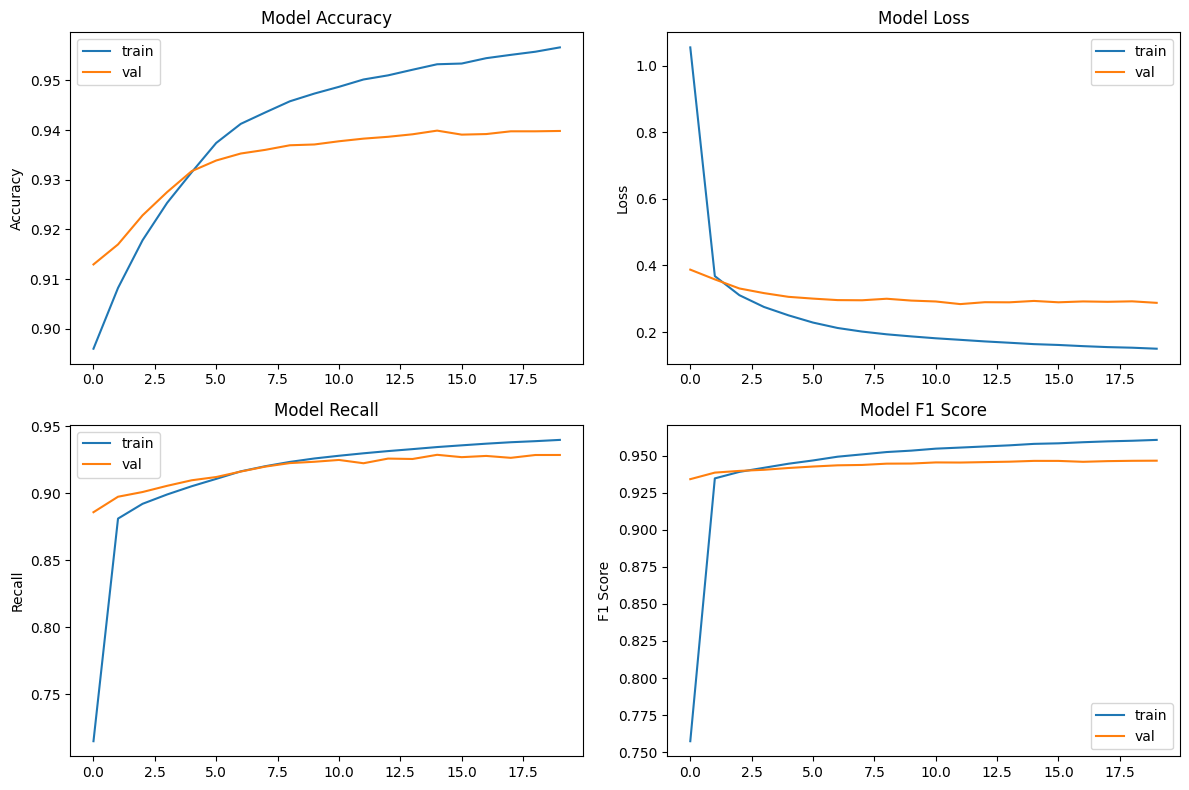

In [21]:
plot_graphs(history)

In [22]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_sequences_padded)

y_pred_labels = np.argmax(y_pred, axis=2)
test_labels_labels = np.argmax(test_labels, axis=2)

print(classification_report(test_labels_labels.reshape(-1), y_pred_labels.reshape(-1), zero_division=0))

28/28 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        15
           2       0.62      0.35      0.45        37
           3       0.86      0.86      0.86        36
           4       0.33      0.25      0.29         4
           6       0.48      0.47      0.47       467
           7       0.65      0.62      0.63       100
           8       0.00      0.00      0.00        16
           9       0.00      0.00      0.00        56
          10       0.38      0.51      0.43        97
          11       0.35      0.26      0.30       478
          12       0.52      0.53      0.53       684
          13       0.42      0.25      0.31       236
          14       0.57      0.46      0.51        65
          15       0.37      0.22      0.28        45
          16       0.00      0.00      0.00        16
          17       0.00      0.00      0.00        11
          19       0.00     